See paper by Guoxu Zhou, Andrzej Cichocki, Yu Zhang, Danilo Mandic, "Group component analysis for multi-block data: common and individual feature extraction"

Assume that we have $N$ data matrices $Y_n \, \in \, \mathbb{R}^{D \times J_n}$ with equal number of rows. We are interested in factorizing them into sum of two terms, common and individual:

$$Y_n \approx \overline{A} \overline{B}_n^T + \underline{A}_n \underline{B}_n^T$$

$\overline{A} \, \in \, \mathbb{R}^{D \times C}$ captures features associated with shared (common) space.

Without loss of generality, three conditions may be possessed:

#### (1) $\overline{A}^T \overline{A} = I_{C}$
(via performing QR decomposition on $\overline{A}$):

$$ \overline{A} = QR,$$
$$\overline{A} \gets Q, \quad  \overline{B}_n \gets \overline{B}_n R^T$$

#### (2)  $\overline{A}^T \underline{A}_n = 0$

$$\underline{A}_n \gets (I - \overline{A} \, \overline{A}^T) \, \underline{A}_n$$

$$\overline{B}_n \gets \overline{B}_n + \underline{B}_n \underline{A}^T_n \overline{A}$$

#### (3) $\underline{A}^T_n \underline{A}_n = I_{R_n - C}$
(via performing SVD on $\underline{A}_n$)

$$ \underline{A}_n = U_n S_n V_n^T $$
$$ \underline{A}_n \gets U_n, \quad \underline{B}_n \gets \underline{B}_n V_n S_n$$

Taking all these conditions in account, we can formulate an optimization task:

$$\min\limits_{\overline{A}, \, \underline{A}_n} \sum\limits_{n} || Y_n - (\overline{A} \overline{B}_n^T + \underline{A}_n \underline{B}_n^T)||^2_F$$
$${s.t.}  \quad \overline{A}^T \overline{A} = I_{C},$$
$$\overline{A}^T \underline{A}_n = 0,$$
$$\underline{A}^T_n \underline{A}_n = I_{R_n - C}$$

### COBE
Common orthogonal basis  extraction algorithm (COBE) is proposed to extract orthogonal $\overline{A}$ defined above.

### COBEC
The COBE algorithm when the number of common components is given via parameter C

### SORTE

(see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.305.1290&rep=rep1&type=pdf )

The second-order statistics of the eigenvalues is a technique to estimate number of task-related eigenvalues of covariance matrix through detection of a gap between these eigenvalues.

$${sorte}(p) = 
\begin{cases}
    \frac{{var}(\{\nabla \lambda_{x,i} \}_{i=p+1}^{m-1})}
    {{var}(\{\nabla \lambda_{x,i} \}_{i=p}^{m-1}} & , & {if} \quad {var}(\{\nabla \lambda_{x,i} \}_{i=p}^{m-1} \neq 0 \\
    +\infty & , & {otherwise} \\
\end{cases}$$

$\nabla \lambda_{x,i} = \lambda_{x,i} - \lambda_{x,i+1}$

$p$ value is delivered by following problem:

$$p = \arg \min_{p} {sorte}(p)$$

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def reshape(a, shape):
    return np.reshape(a, shape, order = 'F')


def fk(Ql, zl, a):
    rv = 0
    N = len(Ql)
    for n in xrange(N):
        rv += np.linalg.norm(np.dot(Ql[n], zl[n]) - a)
    return rv
    
def cobe(Yl, eps = 1e-8, gamma = 1e-8, maxitnum = 20, verbose=False, maxInnerItNum = 500, inform=False):
    # QR factorization
    N = len(Yl)
    Ql = []
    zl = []
    for n in xrange(N):
        Qn, Rn = np.linalg.qr(Yl[n])
        Ql.append(Qn)
        zl.append(np.random.normal(size = [Qn.shape[1], 1]))
    Al = []
    k = 1
    inner_list = []
    fval_list = []
    for itnum in xrange(maxitnum):
        a = np.random.normal(size = [Ql[0].shape[0], 1])
        inner_fvl = []
        for innerItNum in xrange(maxInnerItNum):
            # a update
            anew = np.zeros([Ql[0].shape[0], 1])
            for n in xrange(N):
                anew += np.dot(Ql[n], zl[n])
            anew /= np.linalg.norm(anew)
            # z update
            for n in xrange(N):
                zl[n] = reshape(np.dot(Ql[n].T, anew), [-1,1])
            inner_fvl.append(np.linalg.norm(a - anew))
            a = anew.copy()
            if inner_fvl[-1] < gamma:
                break
        inner_list.append(inner_fvl)
        fval_list.append(fk(Ql, zl, a))
        Al.append(a.copy())
        k += 1
        for n in xrange(N):
            Pmat = np.eye(Ql[n].shape[1]) - np.dot(zl[n], zl[n].T)
            Ql[n] = np.dot(Ql[n], Pmat)
        if verbose:
            print "Itnum: %d/%d\t fval: %.5e\t inner_itnum: %d/%d\t inner_diff: %.5e" % (itnum+1,
                                                                                         maxitnum,
                                                                                         fval_list[-1],
                                                                                         innerItNum+1,
                                                                                         maxInnerItNum,
                                                                                         inner_fvl[-1]
                                                                                         )
        if fval_list[-1] >= eps:
            break
    support = {'fval': fval_list,
               'inner_it': inner_list}
    if inform:
        return np.hstack(Al), support
    return np.hstack(Al)

In [83]:
# COBEC

def cobec(Yl, C, eps = 1e-8, maxitnum=30, verbose=False, inform=False):
    # QR factorization
    N = len(Yl)
    Ql = []
    Zl = []
    fval_list = []
    for n in xrange(N):
        Qn, Rn = np.linalg.qr(Yl[n])
        Ql.append(Qn)
        Zl.append(np.random.normal(size = [Ql[n].shape[1], C]))
    A = np.random.uniform(-1, 1, [Ql[0].shape[0], C])
    for itnum in xrange(maxitnum):
        P = np.zeros([Ql[0].shape[0], Zl[0].shape[1]])
        for n in xrange(N):
            P += np.dot(Ql[n], Zl[n])
        U, S, Vt = np.linalg.svd(P)
        # truncated SVD
        Anew = np.dot(U[:, :C], Vt[:C, :])
        for n in xrange(N):
            Zl[n] = np.dot(Ql[n].T, Anew)
        fval_list.append(np.linalg.norm(A - Anew))
        A = Anew.copy()
        if verbose:
            print "Itnum: %d/%d\t fval: %.5e" % (itnum+1, maxitnum, fval_list[-1])
        if fval_list[-1] < eps:
            break
    if inform:
        support = {'fval': fval_list}
        return A, support
    return A

In [68]:
# SORTE
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.305.1290&rep=rep1&type=pdf
from scipy.optimize import brute # grid search


def sorte_fun(lamb, p):
    m = lamb.size
    assert (p >= 0) and ( p < m-2)
    dlamb = -np.diff(lamb)
    var2 = np.var(dlamb[p:])
    if var2 == 0:
        return np.inf
    return np.var(dlamb[p+1:]) / var2

def sorte(lamb):
    m = lamb.size
    p = brute(my_func, range(m-2), full_output = False)
    return p

In [105]:
# test


S = np.random.normal(size = [2, 1000, 10])
t = np.arange(0, 1000) + 1
S[0, :, 0] = np.sin(0.01*t)
S[1, :, 0] = np.sign(S[0, :, 0])

M1 = np.random.normal(size = [10, 10])
M2 = np.random.normal(size = [10, 10])

S[0, :, :] = np.dot(S[0, :, :], M1.T)
S[1, :, :] = np.dot(S[1, :, :], M2.T)

print S.shape

A = cobe([S[0], S[1]], verbose=True)
B, supB = cobec([S[0], S[1]], 1, verbose=False, maxitnum=800, inform=True)
print supB['fval'][-1]

(2, 1000, 10)
Itnum: 1/20	 fval: 4.59546e-01	 inner_itnum: 42/500	 inner_diff: 7.63939e-09
7.305604402e-09


$a$ - "principal" component of highly correlated (in some sense common) components $S_1(S_1^+ a)$ and $S_2(S_2^+ a)$.

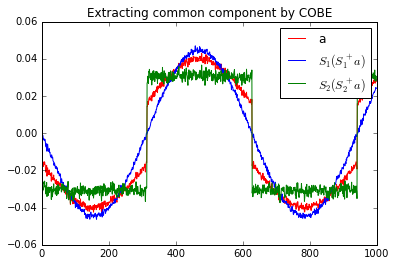

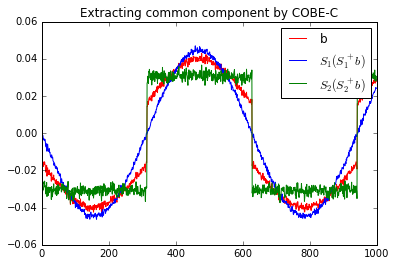

In [109]:
plt.figure()
plt.plot(A[:, 0], 'r', label = 'a')
plt.plot(np.dot(S[0], np.dot(np.linalg.pinv(S[0]), A[:, 0])), 'b', label='$S_1(S_1^+ a)$')
plt.plot(np.dot(S[1], np.dot(np.linalg.pinv(S[1]), A[:, 0])), 'g', label='$S_2(S_2^+ a)$')
plt.legend()
plt.title('Extracting common component by COBE')
plt.show()

numB = 0
plt.figure()
plt.plot(B[:, numB], 'r', label = 'b')
plt.plot(np.dot(S[0], np.dot(np.linalg.pinv(S[0]), B[:, numB])), 'b', label='$S_1(S_1^+ b)$')
plt.plot(np.dot(S[1], np.dot(np.linalg.pinv(S[1]), B[:, numB])), 'g', label='$S_2(S_2^+ b)$')
plt.legend()
plt.title('Extracting common component by COBE-C')
plt.show()

In [62]:
B.shape

(1000, 1)